In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import lasio as la
import seaborn as sns
import bruges as br

%matplotlib inline

# Define a default font for the figures
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 12
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

# Initialize Plotly and Cufflinks
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

# Extract well log data

In [2]:
#love1 = lasio.read('LOEVE-1_LK.las')
#love1.to_csv('LOEVE-1.csv')
love1 = pd.read_csv('LOEVE-1.csv') # Load into panda Data Frame
love1_units = love1.iloc[0] # Store the units
love1.drop([0],inplace=True) # Remove row of units from the Data Frame
love1 = love1[['DEPTH','GR','PHIT','VSHALE','SW','DT','DTCO3','DTSH6','RHOZ']] # Extract relevant logs
love1 = love1.astype(float) # Convert data type to float number
love1[['DT','DTSH6']] = love1[['DT','DTSH6']].apply(lambda x: x * 3.28084) # us/ft --> us/m

rhoLog_strt = love1[love1['RHOZ']!=4628.8]['DEPTH'].iloc[0] # Density log measurements start



# Smoothing and despiking the logs

In [3]:
def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolled = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        
        return rolled
window = 13 # the length of filter is 13 samples or ~ 2 metres

# Smooth density
rho_sm = np.median(rolling_window(love1['RHOZ'],window), -1) # Smooths the logs using a median filter
love1['RHOZ_sm'] = np.pad(rho_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Smooth P-sonic
dt_sm = np.median(rolling_window(love1['DT'],window), -1) # Smooths the logs using a median filter
love1['DT_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Smoothh S-sonic
dts_sm = np.median(rolling_window(love1['DTSH6'],window), -1) # Smooths the logs using a median filter
love1['DTS_sm'] = np.pad(dts_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Despike function
def despike(curve, curve_sm, max_clip): 
    spikes = np.where(curve - curve_sm > max_clip)[0]
    spukes = np.where(curve_sm - curve > max_clip)[0]
    out = np.copy(curve)
    out[spikes] = curve_sm[spikes] + max_clip  # Clip at the max allowed diff
    out[spukes] = curve_sm[spukes] - max_clip  # Clip at the min allowed diff
    return out

love1['RHOZ_edt'] = despike(love1['RHOZ'],love1['RHOZ_sm'],max_clip=100) 
love1['DT_edt'] = despike(love1['DT'],love1['DT_sm'],max_clip=5) 
love1['DTS_edt'] = despike(love1['DTSH6'],love1['DTS_sm'],max_clip=5)

C:\Users\kenb\.conda\envs\obspy\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Series.strides is deprecated and will be removed in a future version

C:\Users\kenb\.conda\envs\obspy\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning:

Invalid value encountered in median for 1 results

C:\Users\kenb\.conda\envs\obspy\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning:

Invalid value encountered in median for 6777 results

C:\Users\kenb\.conda\envs\obspy\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning:

Invalid value encountered in median for 6862 results



In [4]:
# geqReuss, geqVoigt, geqHill
def vrh(f, M1, M2):
    '''
    Simple Voigt-Reuss-Hill bounds for 2-components mixture, (C) aadm 2017

    INPUT
    f: volumetric fraction of mineral 1
    M1: elastic modulus mineral 1
    M2: elastic modulus mineral 2

    OUTPUT
    M_Voigt: upper bound or Voigt average
    M_Reuss: lower bound or Reuss average
    M_VRH: Voigt-Reuss-Hill average
    '''
    M_Voigt = f*M1 + (1-f)*M2
    M_Reuss = 1/ ( f/M1 + (1-f)/M2 )
    M_VRH   = (M_Voigt+M_Reuss)/2
    return M_Voigt, M_Reuss, M_VRH

# Define facies

In [5]:
# Get well tops for plot annotation

tops = pd.read_excel('Loeve_Tops.xlsx')
tops.drop([0],inplace=True)
    
# Define elastic logs
love1['Vp'] = (1e3 / love1['DT_edt'])
#love1['Vs'] = (1e3 / love1['DTS_edt'])

# Predict Vs from Vp (Greenberg-Castagna)
_,_,love1['Vs'] = vrh(love1['VSHALE'],(0.77 * love1['Vp'] - 0.867),(0.79 * love1['Vp'] - 0.85))

love1['AI'] = love1['Vp'] * love1['RHOZ_edt']
love1['PS'] = love1['Vp'] / love1['Vs']

# Crop reservoir interval
resSec = love1[(love1['DEPTH'] >= float(tops[tops['Top'] == 'Bunter SST']['Start']-30)) & (love1['DEPTH'] < float(tops[tops['Top'] == 'Bunter SH']['Start']+20))]

# Subdivide reservoir into ("0") Upper shale zone 1, ("1") Upper shale zone 2, ("2") clean reservoir zone, and ("3") shaly reservoir zone
resSec['F'] = np.zeros(len(resSec))
resSec['F_label'] = ["" for x in range(len(resSec))]
intf = [tops['Start'].loc[8],1823, 1861, 1898, 2050] # interfaces
Fstr = 'Lower Ørslev,Bunter i,Bunter ii,Bunter iii,Bunter iv,Bunter v'
Fstr = Fstr.split(',')

resSec['F'].loc[(resSec['DEPTH'] < intf[0])] = 0
resSec['F'].loc[(resSec['DEPTH'] >= intf[0]) & (resSec['DEPTH'] <= intf[1])] = 1
resSec['F'].loc[(resSec['DEPTH'] > intf[1]) & (resSec['DEPTH'] <= intf[2])] = 2
resSec['F'].loc[(resSec['DEPTH'] > intf[2]) & (resSec['DEPTH'] <= intf[3])] = 3
resSec['F'].loc[(resSec['DEPTH'] > intf[3]) & (resSec['DEPTH'] <= intf[4])] = 4
resSec['F'].loc[(resSec['DEPTH'] > intf[4])] = 5

resSec['F_label'].loc[(resSec['DEPTH'] < intf[0])] = Fstr[0]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[0]) & (resSec['DEPTH'] <= intf[1])] = Fstr[1]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[1]) & (resSec['DEPTH'] <= intf[2])] = Fstr[2]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[2]) & (resSec['DEPTH'] <= intf[3])] = Fstr[3]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[3]) & (resSec['DEPTH'] <= intf[4])] = Fstr[4]
resSec['F_label'].loc[(resSec['DEPTH'] > intf[4])] = Fstr[5]

dz = []
for m in range(0,len(Fstr)):
    dz.append(resSec[resSec['F']==m]['DEPTH'].diff().sum())



# Plot logs and X-plot

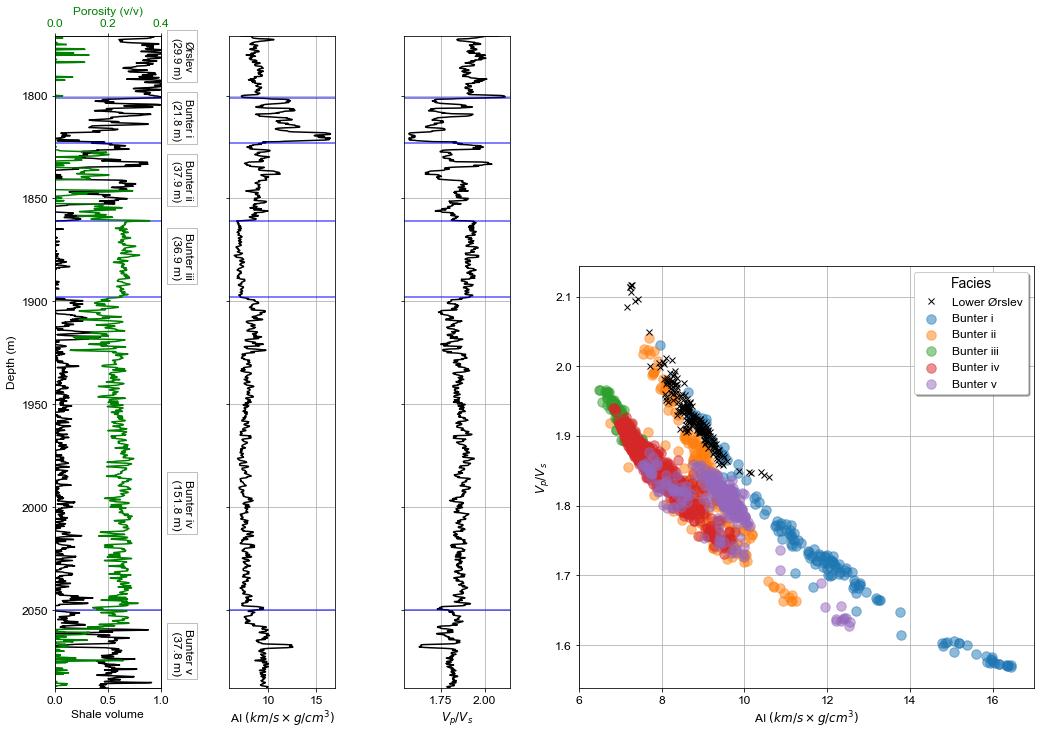

In [6]:
fig = plt.figure(figsize=(16,12))
#
gs1 = gridspec.GridSpec(nrows=3, ncols=6, left = 0.05, wspace=0.65)
ax1a = fig.add_subplot(gs1[:, 0])
ax2 = fig.add_subplot(gs1[:, 1])
ax3 = fig.add_subplot(gs1[:, 2])
ax4 = fig.add_subplot(gs1[1:3, 3:6])

# Shale volume
ax1a.plot(resSec['VSHALE'],resSec['DEPTH'],'k-')
ax1a.axis('tight')
ax1a.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax1a.invert_yaxis()
ax1a.set_xlim(0,1)
ax1a.set_xlabel('Shale volume', fontsize = 12)
ax1a.set_ylabel('Depth (m)', fontsize = 12)
ax1a.grid()

#Porosity
ax1b = ax1a.twiny()  # instantiate a second axes that shares the same x-axis
ax1b.plot(resSec['PHIT'],resSec['DEPTH'],'g-')
ax1b.tick_params(axis='x', labelcolor='g')
ax1b.set_xlabel('Porosity (v/v)', FontSize = 12, color = 'g')
ax1b.set_xlim(0,0.4)

# AI
ax2.plot(resSec['AI'],resSec['DEPTH'],'k-')
ax2.axis('tight')
ax2.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax2.invert_yaxis()
ax2.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax2.set_yticklabels('')
ax2.grid()

# Vp/Vs
ax3.plot(resSec['PS'],resSec['DEPTH'],'k-')
ax3.axis('tight')
ax3.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax3.invert_yaxis()
ax3.set_xlabel(r'$V_p/V_s$', fontsize = 12)
ax3.set_yticklabels('')
ax3.grid()

for n in range(0,len(intf)):
    ax1a.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)    
    ax2.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    ax3.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    
ax1a.text(x = ax1a.set_xlim()[1]+0.2, y =intf[0]-20, s = 'Ørslev\n ({0} m)'.format(str(round(dz[0],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)

ax1a.text(x = ax1a.set_xlim()[1]+0.2, y =intf[0]+10, s = 'Bunter i\n ({0} m)'.format(str(round(dz[1],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)

ax1a.text(x = ax1a.set_xlim()[1]+0.2, y =intf[2]-20, s = 'Bunter ii\n ({0} m)'.format(str(round(dz[2],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)

ax1a.text(x = ax1a.set_xlim()[1]+0.2, y =intf[3]-20, s = 'Bunter iii\n ({0} m)'.format(str(round(dz[3],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)


ax1a.text(x = ax1a.set_xlim()[1]+0.2, y =intf[3]+100, s = 'Bunter iv\n ({0} m)'.format(str(round(dz[4],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)

ax1a.text(x = ax1a.set_xlim()[1]+0.2, y =intf[4]+20, s = 'Bunter v\n ({0} m)'.format(str(round(dz[5],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)

# AI vs Vp/Vs

groups = resSec['F_label'].unique()

for i in range(len(groups)):
    x, y = (resSec[resSec['F_label']==groups[i]]['AI'],resSec[resSec['F_label']==groups[i]]['PS'])
    if (groups[i]=='Lower Ørslev'):
        ax4.plot(resSec[resSec['F_label']==groups[i]]['AI'],resSec[resSec['F_label']==groups[i]]['PS'],'kx',lw=2,label=groups[i])
    else:
        ax4.scatter(x, y, alpha=0.5, s=90, label=groups[i])


ax4.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax4.set_ylabel(r'$V_p/V_s$', fontsize = 12)
ax4.set_xlim(6,17)
ax4.grid()
ax4.set_axisbelow(True)
lg = ax4.legend(loc=1,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

#plt.savefig('Love1_x-plot.png',dpi=400)
plt.show()

# Plot suite of logs

<Figure size 1152x864 with 0 Axes>

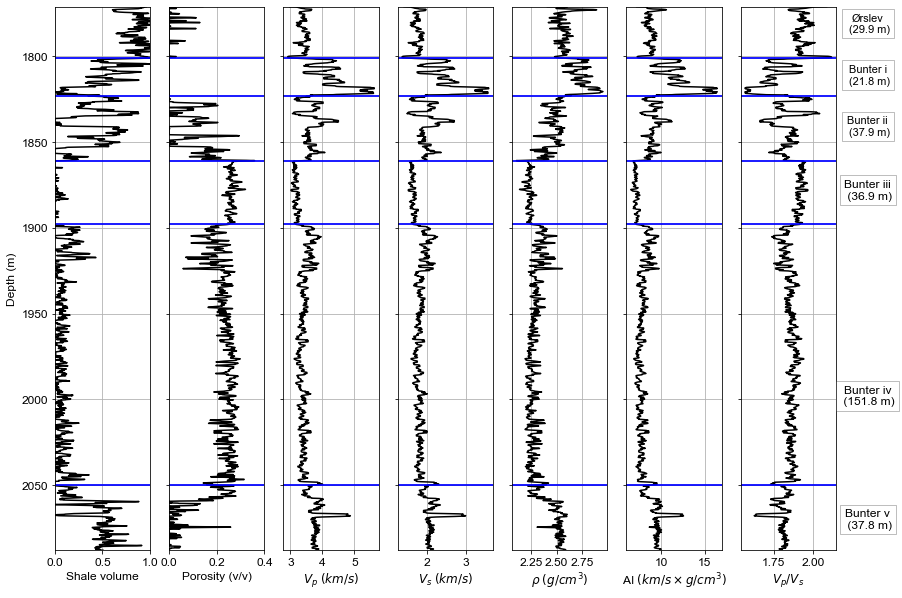

In [7]:
fig = plt.figure(figsize=(16,12))
#
fig, ax = plt.subplots(nrows = 1, ncols = 7,figsize=(14,10))


# Shale volume
ax[0].plot(resSec['VSHALE'],resSec['DEPTH'],'k-')
ax[0].axis('tight')
ax[0].set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax[0].invert_yaxis()
ax[0].set_xlim(0,1)
ax[0].set_xlabel('Shale volume', fontsize = 12)
ax[0].set_ylabel('Depth (m)', fontsize = 12)
ax[0].grid()

#Porosity
ax[1].plot(resSec['PHIT'],resSec['DEPTH'],'k-')
ax[1].set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax[1].invert_yaxis()
ax[1].set_xlim(0,0.4)
ax[1].set_xlabel('Porosity (v/v)', FontSize = 12)
ax[1].set_yticklabels('')
ax[1].grid()

# P-velocity
ax[2].plot(resSec['Vp'],resSec['DEPTH'],'k-')
ax[2].axis('tight')
ax[2].set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax[2].invert_yaxis()
ax[2].set_xlabel(r'$V_p$ ' + r'$(km/s)$', fontsize = 12)
ax[2].set_yticklabels('')
ax[2].grid()

# P-velocity
ax[3].plot(resSec['Vs'],resSec['DEPTH'],'k-')
ax[3].axis('tight')
ax[3].set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax[3].invert_yaxis()
ax[3].set_xlabel(r'$V_s$ ' + r'$(km/s)$', fontsize = 12)
ax[3].set_yticklabels('')
ax[3].grid()

# Density
ax[4].plot(resSec['RHOZ'],resSec['DEPTH'],'k-')
ax[4].axis('tight')
ax[4].set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax[4].invert_yaxis()
ax[4].set_xlabel(r'$\rho$ ' + r'$(g/cm^3)$', fontsize = 12)
ax[4].set_yticklabels('')
ax[4].grid()

# AI
ax[5].plot(resSec['AI'],resSec['DEPTH'],'k-')
ax[5].axis('tight')
ax[5].set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax[5].invert_yaxis()
ax[5].set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax[5].set_yticklabels('')
ax[5].grid()

# Vp/Vs
ax[6].plot(resSec['PS'],resSec['DEPTH'],'k-')
ax[6].axis('tight')
ax[6].set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax[6].invert_yaxis()
ax[6].set_xlabel(r'$V_p/V_s$', fontsize = 12)
ax[6].set_yticklabels('')
ax[6].grid()

for i in range(0,7):
    for n in range(0,len(intf)):
        ax[i].axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                       alpha = 0.5)    
        ax[i].axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                       alpha = 0.5)
        ax[i].axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                       alpha = 0.5)
    
ax[-1].text(x = ax[-1].set_xlim()[1]+0.2, y =intf[0]-20, s = 'Ørslev\n ({0} m)'.format(str(round(dz[0],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=0)

ax[-1].text(x = ax[-1].set_xlim()[1]+0.2, y =intf[0]+10, s = 'Bunter i\n ({0} m)'.format(str(round(dz[1],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=0)

ax[-1].text(x = ax[-1].set_xlim()[1]+0.2, y =intf[2]-20, s = 'Bunter ii\n ({0} m)'.format(str(round(dz[2],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=0)

ax[-1].text(x = ax[-1].set_xlim()[1]+0.2, y =intf[3]-20, s = 'Bunter iii\n ({0} m)'.format(str(round(dz[3],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=0)


ax[-1].text(x = ax[-1].set_xlim()[1]+0.2, y =intf[3]+100, s = 'Bunter iv\n ({0} m)'.format(str(round(dz[4],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=0)

ax[-1].text(x = ax[-1].set_xlim()[1]+0.2, y =intf[4]+20, s = 'Bunter v\n ({0} m)'.format(str(round(dz[5],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=0)

#plt.savefig('Love1_log_data.pdf')
plt.show()

# Blocky model input

In [8]:
###########################################################
#       DEFINE MODELING PARAMETERS HERE

#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]

vp_mod = resSec.groupby('F').mean()['Vp']*1e3  # P-wave velocity (m/s)

vs_mod = resSec.groupby('F').mean()['Vs']*1e3  # S-wave velocity (m/s)

rho_mod = resSec.groupby('F').mean()['RHOZ_edt']  # Density

lit_mod = resSec.groupby('F').mean()['VSHALE']  # Shale

phi_mod = resSec.groupby('F').mean()['PHIT']  # Density


thickness = np.round(dz,1)[1:-1] # vertical thickness of layer 2 in metres

#   Angle range for incident rays
theta1_min = 0.0    # best to leave this set to zero
theta1_max = 40.0
theta1_step= 1.0


#   Wavelet Parameters
wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.128 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 35.0  # Ricker wavelet central frequency
f1 = 3.0          # Bandpass wavelet low truncation frequency
f2 = 8.0          # Bandpass wavelet low cut frequency
f3 = 50.0          # Bandpass wavelet high cut frequency
f4 = 65.0          # Bandpass wavelet high truncation frequency


#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality


#   Plotting Display Parameters
min_plot_time = 0.02
max_plot_time = 0.25
excursion = 2

# Function definitions

In [9]:
def plot_vawig(axhdl, data, t, excursion):

    import numpy as np
    import matplotlib.pyplot as plt

    [ntrc, nsamp] = data.shape
    

    
    
    t = np.hstack([0, t, t.max()])
    
    for i in range(0, ntrc):
        tbuf = excursion * data[i,:] / np.max(np.abs(data)) + i
        
        tbuf = np.hstack([i, tbuf, i])
            
        axhdl.plot(tbuf, t, color='black', linewidth=0.5)
        plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor='k', linewidth=0, alpha=0.5)
        #plt.fill_betweenx(t, tbuf, i, where=tbuf<i, facecolor=[0.6,0.6,1.0], linewidth=0)
    
    axhdl.set_xlim((-excursion, ntrc+excursion))
    axhdl.xaxis.tick_top()
    axhdl.xaxis.set_label_position('top')
    axhdl.invert_yaxis()
    
  
    
def ricker(cfreq, phase, dt, wvlt_length):
    '''
    Calculate a zero-phase ricker wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)
    
    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    import numpy as np
    import scipy.signal as signal
    
    nsamp = int(wvlt_length/dt + 1)
    t_max = wvlt_length*0.5
    t_min = -t_max
    
    t = np.arange(t_min, t_max, dt)
    
    t = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)
    wvlt = (1.0 - 2.0*(np.pi**2)*(cfreq**2)*(t**2)) * np.exp(-(np.pi**2)*(cfreq**2)*(t**2))
    
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt



def wvlt_bpass(f1, f2, f3, f4, phase, dt, wvlt_length):
    '''
    Calculate a trapezoidal bandpass wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(f1, f2, f3, f4, phase, dt, wvlt_length)
    
    f1: Low truncation frequency of wavelet in Hz
    f2: Low cut frequency of wavelet in Hz
    f3: High cut frequency of wavelet in Hz
    f4: High truncation frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift
    
    nsamp = int(wvlt_length/dt + 1)
    
    
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    aspec = freq*0.0
    pspec = freq*0.0
    
    # Calculate slope and y-int for low frequency ramp
    M1 = 1/(f2-f1)
    b1 = -M1*f1
    
    # Calculate slop and y-int for high frequency ramp
    M2 = -1/(f4-f3)
    b2 = -M2*f4
    
    # Build initial frequency and filter arrays
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    filt = np.zeros(nsamp)
    
    # Build LF ramp
    idx = np.nonzero((np.abs(freq)>=f1) & (np.abs(freq)<f2))
    filt[idx] = M1*np.abs(freq)[idx]+b1
    
    # Build central filter flat
    idx = np.nonzero((np.abs(freq)>=f2) & (np.abs(freq)<=f3))
    filt[idx] = 1.0
    
    # Build HF ramp
    idx = np.nonzero((np.abs(freq)>f3) & (np.abs(freq)<=f4))
    filt[idx] = M2*np.abs(freq)[idx]+b2
    
    # Unshift the frequencies and convert filter to fourier coefficients
    filt2 = ifftshift(filt)
    Af = filt2*np.exp(np.zeros(filt2.shape)*1j)
    
    # Convert filter to time-domain wavelet
    wvlt = fftshift(ifft(Af))
    wvlt = np.real(wvlt)
    wvlt = wvlt/np.max(np.abs(wvlt)) # normalize wavelet by peak amplitude

    # Generate array of wavelet times
    t = np.linspace(-wvlt_length*0.5, wvlt_length*0.5, nsamp)
    
    
    # Apply phase rotation if desired
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt
    
    

def calc_times(z_int, vp_mod):
    '''
    Calculate two-way travel time through a layered model
    
    Usage:
    -----
    t_int = calc_times(z_int, vp_mod)
    
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i]/vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i]-z_int[i-1]
            zdiff = zdiff*2.0   # multiply by 2 for two-way traveltimes
            tbuf = zdiff/vp_mod[i] + t_int[i-1]
            tbuf = tbuf
            t_int.append(tbuf)
    
    return t_int

In [10]:
def digitize_model(rc_int, t_int, t):
    '''
    Sample a simple layered reflectivity model
    
    Usage:
    ------
    rc = digitize_model(rc, t_int, t)
    
    rc = reflection coefficients corresponding to interface times
    t_int = interface times
    t = regularly sampled time series defining model sampling
    '''
    
    import numpy as np
    
    nlayers = len(rc_int)
    nint = nlayers - 1
    nsamp = len(t)
    
    rc = list(np.zeros(nsamp,dtype='float'))
    lyr = 0
    
    for i in range(0, nsamp):

        if t[i] >= t_int[lyr]:
            rc[i] = rc_int[lyr]
            lyr = lyr + 1    

        if lyr > nint:
            break
            
    return rc
    

def rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1):
    '''
    Reflection & Transmission coefficients calculated using full Zoeppritz
    equations.
    
    Usage:
    ------
    R = rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1)
    
    Reference:
    ----------
    The Rock Physics Handbook, Dvorkin et al.
    '''
    
    import math
    
    # Cast inputs to floats
    vp1  = float(vp1)
    vp2  = float(vp2)
    vs1  = float(vs1)
    vs2  = float(vs2)
    rho1 = float(rho1)
    rho2 = float(rho2)
    theta1 = float(theta1)
    
    # Calculate reflection & transmission angles
    theta1 = math.radians(theta1)   # Convert theta1 to radians
    p      = ray_param(vp1, math.degrees(theta1)) # Ray parameter
    theta2 = math.asin(p*vp2);      # Transmission angle of P-wave
    phi1   = math.asin(p*vs1);      # Reflection angle of converted S-wave
    phi2   = math.asin(p*vs2);      # Transmission angle of converted S-wave
    
    # Matrix form of Zoeppritz Equations... M & N are two of the matricies
    M = np.array([ \
        [-math.sin(theta1), -math.cos(phi1), math.sin(theta2), math.cos(phi2)],\
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],\
        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),\
            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],\
        [-rho1*vp1*(1-2*math.sin(phi1)**2), rho1*vs1*math.sin(2*phi1), \
            rho2*vp2*(1-2*math.sin(phi2)**2), -rho2*vs2*math.sin(2*phi2)]
        ], dtype='float')
    
    N = np.array([ \
        [math.sin(theta1), math.cos(phi1), -math.sin(theta2), -math.cos(phi2)],\
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],\
        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),\
            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],\
        [rho1*vp1*(1-2*math.sin(phi1)**2), -rho1*vs1*math.sin(2*phi1),\
            -rho2*vp2*(1-2*math.sin(phi2)**2), rho2*vs2*math.sin(2*phi2)]\
        ], dtype='float')
    
    # This is the important step, calculating coefficients for all modes and rays
    R = np.dot(np.linalg.inv(M), N);
    
    return R


def ray_param(v, theta):
    '''
    Calculates the ray parameter p
    
    Usage:
    ------
        p = ray_param(v, theta)
    
    Inputs:
    -------
            v = interval velocity
        theta = incidence angle of ray (degrees)
    
    Output:
    -------
        p = ray parameter (i.e. sin(theta)/v )
    '''
    
    import math
    
    # Cast inputs to floats
    theta = float(theta)
    v = float(v)
    
    p = math.sin(math.radians(theta))/v # ray parameter calculation
    
    return p

# Computations

In [11]:
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nangles = int( (theta1_max-theta1_min)/theta1_step + 1)


#   Generate wavelet
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

#   Apply amplitude scale factor to wavelet (to match seismic amplitude values)
wvlt_amp = wvlt_scalar * wvlt_amp

#   Calculate reflectivities from model parameters
rc_zoep_pp = []
theta1 = []
for i in range(0, nangles):
    theta1_buf = i*theta1_step + theta1_min
    rc_buf1 = rc_zoep(vp_mod[0], vs_mod[0], rho_mod[0], vp_mod[1], vs_mod[1], rho_mod[1], theta1_buf)
    rc_buf2 = rc_zoep(vp_mod[1], vs_mod[1], rho_mod[1], vp_mod[2], vs_mod[2], rho_mod[2], theta1_buf)
    rc_buf3 = rc_zoep(vp_mod[2], vs_mod[2], rho_mod[2], vp_mod[3], vs_mod[3], rho_mod[3], theta1_buf)
    rc_buf4 = rc_zoep(vp_mod[3], vs_mod[3], rho_mod[3], vp_mod[4], vs_mod[4], rho_mod[4], theta1_buf)
    rc_buf5 = rc_zoep(vp_mod[4], vs_mod[4], rho_mod[4], vp_mod[5], vs_mod[5], rho_mod[5], theta1_buf)
    
    theta1.append(theta1_buf)
    rc_zoep_pp.append([rc_buf1[0,0], rc_buf2[0,0], rc_buf3[0,0], rc_buf4[0,0], rc_buf5[0,0]])


#   Define time sample vector for output model & traces
nsamp = int((tmax-tmin)/dt) + 1
t = []
for i in range(0,nsamp):
    t.append(i*dt)


syn_zoep_pp = []
lyr_times = []
#print("\n\nStarting synthetic calcuations...\n")
for angle in range(0, nangles):
    
    dz_app = thickness
    
    #   To calculate apparent thickness of layer 2 based on incidence angle
    #   uncomment the following three rows (e.g. ray-synthetics)
    #p = ray_param(vp_mod[0], angle)
    #angle2 = math.degrees(math.asin(p*vp_mod[1]))
    #dz_app = thickness/math.cos(math.radians(angle2))
    
    #   Calculate interface depths
    z_int = [200, 0, 0, 0, 0]
    for i in range(1,nint):
        z_int[i] = z_int[i-1]+dz_app[i-1]
    
    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    rc = digitize_model(rc_zoep_pp[angle], t_int, t)

    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    #syn_buf = list(syn_buf)
    syn_zoep_pp.append(syn_buf)
    print("Calculated angle %i" % (angle))


#    Convert data arrays from lists/tuples to numpy arrays    
syn_zoep_pp = np.array(syn_zoep_pp)
rc_zoep_pp = np.array(rc_zoep_pp)
t = np.array(t)


#   Calculate array indicies corresponding to top/base interfaces
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')
lyr1_indx = list(lyr_indx[:,0])
lyr2_indx = list(lyr_indx[:,1])
lyr3_indx = list(lyr_indx[:,2])
lyr4_indx = list(lyr_indx[:,3])
lyr5_indx = list(lyr_indx[:,4])

#   Copy convolved top/base reflectivity values to Lists for easier plotting
[ntrc, nsamp] = syn_zoep_pp.shape
line1 = []
line2 = []
line3 = []
line4 = []
line5 = []
for i in range(0, ntrc):
    line1.append(syn_zoep_pp[i,lyr1_indx[i]])
    line2.append(syn_zoep_pp[i,lyr2_indx[i]])
    line3.append(syn_zoep_pp[i,lyr3_indx[i]])
    line4.append(syn_zoep_pp[i,lyr4_indx[i]])
    line5.append(syn_zoep_pp[i,lyr5_indx[i]])

#   AVO inversion for NI and GRAD from analytic and convolved reflectivity
#   values and print the results to the command line.  Linear least squares
#   method is used for estimating NI and GRAD coefficients.
Yzoep = np.array(rc_zoep_pp[:,0])
Yzoep = Yzoep.reshape((ntrc, 1))

Yconv = np.array(line1)
Yconv = Yconv.reshape((ntrc, 1))

ones = np.ones(ntrc)
ones = ones.reshape((ntrc,1))

sintheta2 = np.sin(np.radians(np.arange(0, ntrc)))**2
sintheta2 = sintheta2.reshape((ntrc, 1))

X = np.hstack((ones, sintheta2))

#   ... matrix solution of normal equations
Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)

#print('\n\n')
#print( '  Method       NI         GRAD')
#print( '---------------------------------')
#print( ' Zoeppritz%11.5f%12.5f' % (Azoep[0], Azoep[1]))
#print( ' Convolved%10.5f%12.5f' % (Aconv[0], Aconv[1]))


    
#   Create a "digital" time domain version of the input property model for 
#   easy plotting and comparison with the time synthetic traces
vp_dig = np.zeros(t.shape)
vs_dig = np.zeros(t.shape)
rho_dig = np.zeros(t.shape)
lit_dig = np.zeros(t.shape)
phi_dig = np.zeros(t.shape)

vp_dig[0:lyr1_indx[0]] = vp_mod[0]
vp_dig[(lyr1_indx[0]):lyr2_indx[0]] = vp_mod[1]
vp_dig[(lyr2_indx[0]):lyr3_indx[0]] = vp_mod[2]
vp_dig[(lyr3_indx[0]):lyr4_indx[0]] = vp_mod[3]
vp_dig[(lyr4_indx[0]):lyr5_indx[0]] = vp_mod[4]
vp_dig[(lyr5_indx[0]):] = vp_mod[5]

vs_dig[0:lyr1_indx[0]] = vs_mod[0]
vs_dig[(lyr1_indx[0]):lyr2_indx[0]] = vs_mod[1]
vs_dig[(lyr2_indx[0]):lyr3_indx[0]] = vs_mod[2]
vs_dig[(lyr3_indx[0]):lyr4_indx[0]] = vs_mod[3]
vs_dig[(lyr4_indx[0]):lyr5_indx[0]] = vs_mod[4]
vs_dig[(lyr5_indx[0]):] = vs_mod[5]

rho_dig[0:lyr1_indx[0]] = rho_mod[0]
rho_dig[(lyr1_indx[0]):lyr2_indx[0]] = rho_mod[1]
rho_dig[(lyr2_indx[0]):lyr3_indx[0]] = rho_mod[2]
rho_dig[(lyr3_indx[0]):lyr4_indx[0]] = rho_mod[3]
rho_dig[(lyr4_indx[0]):lyr5_indx[0]] = rho_mod[4]
rho_dig[(lyr5_indx[0]):] = rho_mod[5]

lit_dig[0:lyr1_indx[0]] = lit_mod[0]
lit_dig[(lyr1_indx[0]):lyr2_indx[0]] = lit_mod[1]
lit_dig[(lyr2_indx[0]):lyr3_indx[0]] = lit_mod[2]
lit_dig[(lyr3_indx[0]):lyr4_indx[0]] = lit_mod[3]
lit_dig[(lyr4_indx[0]):lyr5_indx[0]] = lit_mod[4]
lit_dig[(lyr5_indx[0]):] = lit_mod[5]

phi_dig[0:lyr1_indx[0]] = phi_mod[0]
phi_dig[(lyr1_indx[0]):lyr2_indx[0]] = phi_mod[1]
phi_dig[(lyr2_indx[0]):lyr3_indx[0]] = phi_mod[2]
phi_dig[(lyr3_indx[0]):lyr4_indx[0]] = phi_mod[3]
phi_dig[(lyr4_indx[0]):lyr5_indx[0]] = phi_mod[4]
phi_dig[(lyr5_indx[0]):] = phi_mod[5]


C:\Users\kenb\.conda\envs\obspy\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



Calculated angle 0
Calculated angle 1
Calculated angle 2
Calculated angle 3
Calculated angle 4
Calculated angle 5
Calculated angle 6
Calculated angle 7
Calculated angle 8
Calculated angle 9
Calculated angle 10
Calculated angle 11
Calculated angle 12
Calculated angle 13
Calculated angle 14
Calculated angle 15
Calculated angle 16
Calculated angle 17
Calculated angle 18
Calculated angle 19
Calculated angle 20
Calculated angle 21
Calculated angle 22
Calculated angle 23
Calculated angle 24
Calculated angle 25
Calculated angle 26
Calculated angle 27
Calculated angle 28
Calculated angle 29
Calculated angle 30
Calculated angle 31
Calculated angle 32
Calculated angle 33
Calculated angle 34
Calculated angle 35
Calculated angle 36
Calculated angle 37
Calculated angle 38
Calculated angle 39
Calculated angle 40


# Plotting

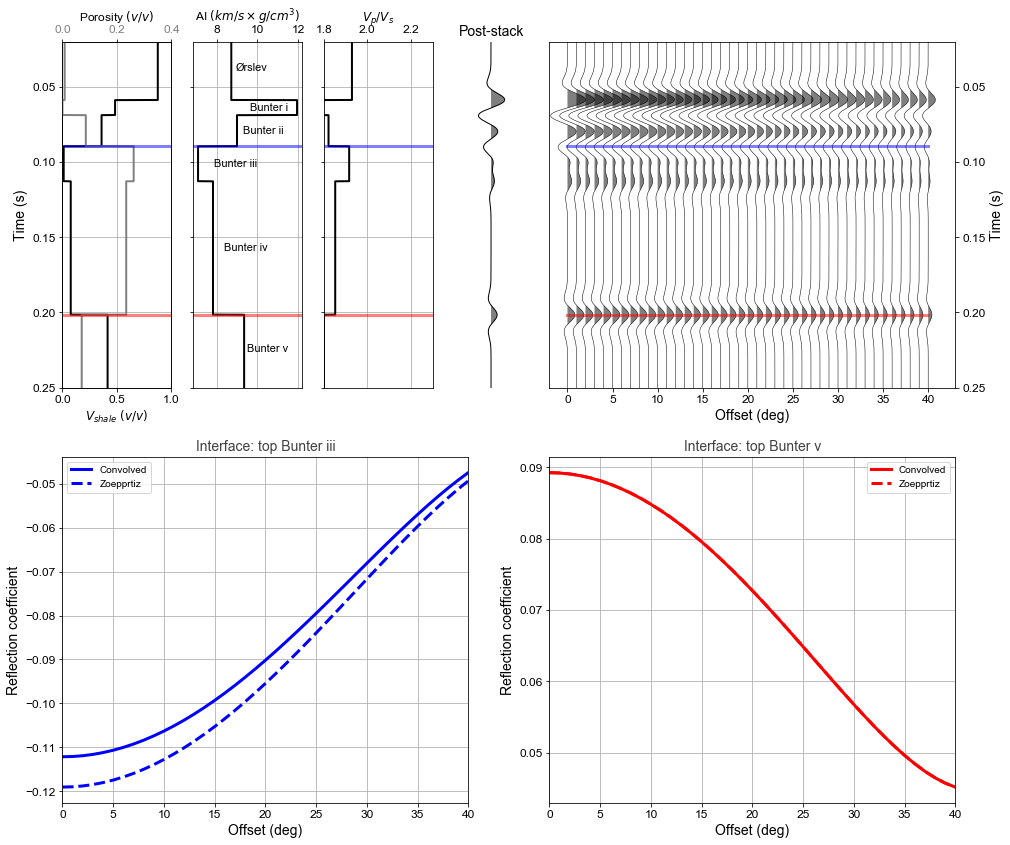

In [12]:
#############################################
#
#       PLOTTING HAPPENS BELOW HERE
#


#   Create the plot figure
fig = plt.figure(figsize=(16, 14))
fig.set_facecolor('white')


#   Plot log curves in two-way time
ax0a = fig.add_subplot(2,7,1)
l_lit_dig, = ax0a.plot(lit_dig, t, 'k', lw=2)
ax0a.set_ylim((min_plot_time,max_plot_time))
ax0a.set_xlim(0, 1.0)
ax0a.invert_yaxis()
ax0a.set_ylabel('Time (s)', fontsize = 14)
ax0a.xaxis.tick_bottom()
ax0a.xaxis.set_label_position('bottom')
ax0a.set_xlabel(r'$V_{shale} \ (v/v)$', fontsize = 12)
ax0a.grid()

cl = 'grey'
ax0a2 = ax0a.twiny()  # instantiate a second axes that shares the same y-axis
l_phi_dig = ax0a2.plot(phi_dig, t, color=cl,lw=2)
ax0a2.tick_params(axis='x', labelcolor=cl)
ax0a2.set_xlabel('Porosity ' + r'$(v/v)$', fontsize = 12)
ax0a2.set_xlim(0,0.4)
ax0a2.axhline(lyr_times[0,2], color='blue', lw=3, alpha=0.5)
ax0a2.axhline(lyr_times[0,4], color='red', lw=3, alpha=0.5)

ax0b = fig.add_subplot(272)
l_ai_dig, = ax0b.plot((vp_dig/1000)*rho_dig, t, 'k', lw=2)
ax0b.set_ylim((min_plot_time,max_plot_time))
ax0b.invert_yaxis()
ax0b.xaxis.tick_top()
ax0b.xaxis.set_label_position('top')
ax0b.set_xlabel('AI ' + r'$(km/s \times g/cm^3)$', fontsize = 12)
ax0b.set_yticklabels('')
ax0b.axhline(lyr_times[0,2], color='blue', lw=3, alpha=0.5)
ax0b.axhline(lyr_times[0,4], color='red', lw=3, alpha=0.5)
ax0b.grid()

plt.text(10.5,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        'Ørslev',
        fontsize=11,
        horizontalalignment='right')
plt.text(11.5,
        lyr_times[0,1] + (lyr_times[0,0] - lyr_times[0,1])/2. + 0.002,
        'Bunter i',
        fontsize=11,
        horizontalalignment='right')
plt.text(11.3,
        lyr_times[0,2] + (lyr_times[0,1] - lyr_times[0,2])/2. + 0.002,
        'Bunter ii',
        fontsize=11,
        horizontalalignment='right')
plt.text(10,
        lyr_times[0,3] + (lyr_times[0,2] - lyr_times[0,3])/2. + 0.002,
        'Bunter iii',
        fontsize=11,
        horizontalalignment='right')
plt.text(10.5,
        lyr_times[0,4] + (lyr_times[0,3] - lyr_times[0,4])/2. + 0.002,
        'Bunter iv',
        fontsize=11,
        horizontalalignment='right')
plt.text(11.5,
        lyr_times[0,4] + (max_plot_time - lyr_times[0,4])/2.,
        'Bunter v',
        fontsize=11,
        horizontalalignment='right')

ax0c = fig.add_subplot(273)
l_ps_dig, = ax0c.plot(vp_dig/vs_dig, t, 'k', lw=2)
ax0c.set_ylim((min_plot_time,max_plot_time))
ax0c.invert_yaxis()
ax0c.xaxis.tick_top()
ax0c.xaxis.set_label_position('top')
ax0c.set_xlabel(r'$V_p/V_s$', fontsize = 12)
ax0c.set_xlim([1.8,2.3])
ax0c.set_yticklabels('')
ax0c.axhline(lyr_times[0,2], color='blue', lw=3, alpha=0.5)
ax0c.axhline(lyr_times[0,4], color='red', lw=3, alpha=0.5)
ax0c.grid()

# Plot post-stack trace
ax1 = fig.add_subplot(2,26,13)
pst = syn_zoep_pp.T.sum(axis=1) # Stacked trace
ax1.plot(pst,t,'k',lw=1)
ax1.fill_betweenx(t, pst, 0, pst>0, facecolor='k', linewidth=0,alpha=0.5)
#ax1.fill_betweenx(t, pst, 0, pst<0, facecolor=[0.6,0.6,1.0], linewidth=0)
ax1.set_ylim((min_plot_time,max_plot_time))
ax1.invert_yaxis()
ax1.set_axis_off()
ax1.set_title('Post-stack', fontsize=14)

# Plot pre-stack traces
ax2 = fig.add_subplot(222)
plot_vawig(ax2, syn_zoep_pp, t, excursion)
ax2.set_ylim((min_plot_time,max_plot_time))
l_int3 = ax2.plot(lyr_times[:,2], color='blue', lw=3, alpha = 0.5)
l_int5 = ax2.plot(lyr_times[:,4], color='red', lw=3, alpha = 0.5)
ax2.invert_yaxis()
#label_str = 'Synthetic angle gather\nLayer 2 thickness = %4.1fm' % thickness
ax2.set_xlabel('Offset (deg)', fontsize = 14)
ax2.xaxis.tick_bottom()
ax2.xaxis.set_label_position('bottom')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Time (s)', fontsize = 14)

#   Plot Zoeppritz and convolved reflectivity curves    
ax3 = fig.add_subplot(2,2,3)

l_syn1, = ax3.plot(line3, color='blue', linewidth=3)
l_rc1, = ax3.plot( rc_zoep_pp[:,2], '--', color='blue', lw=3)
ax3.set_xlim(0,40)
ax3.grid()
ax3.set_xlabel('Offset (deg)', fontsize = 14)
ax3.set_ylabel('Reflection coefficient', fontsize = 14)
ax3.set_title('Interface: top Bunter iii', fontsize = 14, alpha = 0.75)
plt.legend([l_syn1, l_rc1], ['Convolved', 'Zoepprtiz'], loc=0)

ax4 = fig.add_subplot(2,2,4)
l_syn2, = ax4.plot(line5, color='red', linewidth=3)
l_rc2, = ax4.plot( rc_zoep_pp[:,4], '--', color='red', lw=3)
ax4.set_xlim(0,40)
ax4.grid()
ax4.set_xlabel('Offset (deg)', fontsize = 14)
ax4.set_ylabel('Reflection coefficient', fontsize = 14)
ax4.set_title('Interface: top Bunter v', fontsize = 14, alpha = 0.75)
plt.legend([l_syn2, l_rc2], ['Convolved', 'Zoepprtiz'], loc=0)

#   Save the plot
plt.savefig('Love1_AVO_mod1.png',dpi = 400)

#   Display the plot
plt.show()

# Fig caption

To investigate the seismic characteristics of the Bunter Formation, we perform a blocky AVO modeling approach. Figure x(a-c) shows the average P and S-velocities and density for the various formations within our target interval. Figure x(d) shows the corresponding post-stack trace generated from the pre-stack traces in Figure x(e). Zoeppritz equations are used to calculate the reflection coefficients, which are then convolved with a 30 Hz Ricker wavelet. Figure x(f) and x(g) show the reflection coefficients as function of incidence angle for two interfaces: Top Bunter iii and Top Bunter v, respectively. Both the Zoeppritz and convolved reflection coefficients are shown to investigate possible tuning effects, which are insignificant for both of these interfaces.

Comparing the post-stack trace in Figure x(d) with a seismic subsection extending beyond the Løve-1 position, we see that we have managed to reproduce the key seismic reflection events, although we also observe that there are some discripnanies in the amplitude strengths and positioning. This simplified approach is of course unable to exactly reproduce the seismic character from field data which is influenced by coherent and random noise, acquisition configurations and data processing. However, we still manage to itentify the key events for the targeted Bunter Formation, which are consistent with the contrasts in acoustic impedance and Vp/Vs measurements from Løve-1. The two most powerful amplitude signals are the two first arriving events: a red peak followed by a blue trought; representing the Ørslev-to-Bunter (i) and Bunter (i)-to-Bunter (ii) interfaces, respectively. The top Bunter iii interface is characterized by a reatively weak trough, and this is consistent with what we see in the seismic section in Figure y, where a relatively weak and partly discontinous event can be identified. Because the top Bunter iii event is not easily interpretable and is more prone to tuning effects, we rather focus on the base Bunter iv interface for amplitude analysis, i.e. the Bunter (iv)-to-Bunter (v) transition. In addition, we observe that there is a red peak event beneath the top Bunter ii reflection, which is a product of constructive interfering wavelet sidelobes from the top interfaces of Bunter ii and iii. This is event is also identified in the seismic section in Figure y.

Next, we introduce the calibrated rock physics model to calculate a some different reservoir scenarios for the Bunter Formation (Dvorkin et al., 2014). We adjust the porosity and shale volume logs to simulate other possible geological properties, and then use these as input to our rock physics model to calculate the corresponding P and S-velocities and densities.

...



(Acknowledgements: We thank the open-source community at SEG wiki tutorials for sharing the python scripts, which we have used and customized for our research.)


# Rock physics: Function definitions

In [14]:
goodQuality = pd.read_csv('Phi10add_v2.txt',sep=",",header=None,names=['DEPTH','Vp','Vs','RHOZ_edt','PHIT','VSHALE','SW'])
poorQuality = pd.read_csv('Phi10sub_lit15add_v2.txt',sep=",",header=None,names=['DEPTH','Vp','Vs','RHOZ_edt','PHIT','VSHALE','SW'])

# Calculate AI and VpVs
goodQuality['AI'] = goodQuality['Vp'] * goodQuality['RHOZ_edt']
goodQuality['PS'] = goodQuality['Vp'] / goodQuality['Vs']
poorQuality['AI'] = poorQuality['Vp'] * poorQuality['RHOZ_edt']
poorQuality['PS'] = poorQuality['Vp'] / poorQuality['Vs']


# Condensate the modeled interval with the above and below intervals
goodQuality = pd.concat([resSec[resSec['DEPTH']<=1861], goodQuality, resSec[resSec['DEPTH']>=2050]])
poorQuality = pd.concat([resSec[resSec['DEPTH']<=1861], poorQuality, resSec[resSec['DEPTH']>=2050]])

# Reset facies label variables
goodQuality.drop(['F_label','F'],axis=1,inplace=True)
goodQuality.index = resSec.index
goodQuality[['F_label','F']] = resSec[['F_label','F']]

poorQuality.drop(['F_label','F'],axis=1,inplace=True)
poorQuality.index = resSec.index
poorQuality[['F_label','F']] = resSec[['F_label','F']]


C:\Users\kenb\.conda\envs\obspy\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\kenb\.conda\envs\obspy\lib\site-packages\ipykernel_launcher.py:13: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




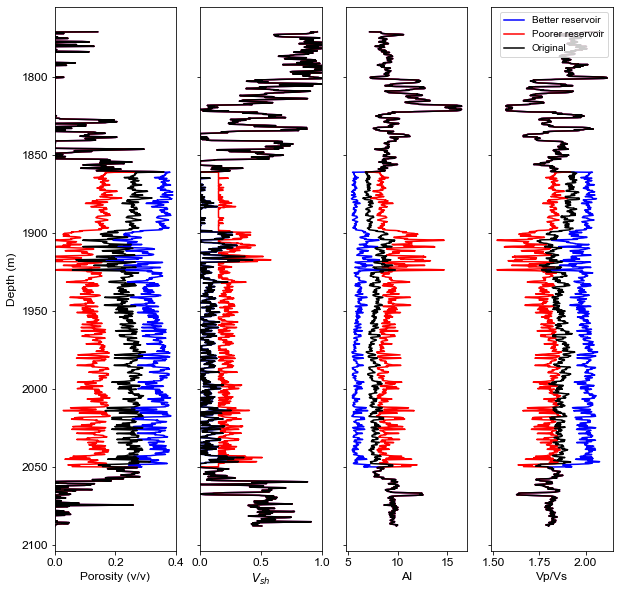

In [15]:
fig, ax = plt.subplots(ncols=4,nrows=1,figsize=(10,10))
ax[0].plot(goodQuality['PHIT'],goodQuality['DEPTH'],'b')
ax[0].plot(poorQuality['PHIT'],poorQuality['DEPTH'],'r')
ax[0].plot(resSec['PHIT'],resSec['DEPTH'],'k')
ax[0].set_xlim(0,0.4)
ax[0].invert_yaxis()
ax[0].set_xlabel('Porosity (v/v)', fontsize = 12)
ax[0].set_ylabel('Depth (m)', fontsize = 12)

ax[1].plot(goodQuality['VSHALE'],goodQuality['DEPTH'],'b')
ax[1].plot(poorQuality['VSHALE'],poorQuality['DEPTH'],'r')
ax[1].plot(resSec['VSHALE'],resSec['DEPTH'],'k')
ax[1].set_xlim(0,1)
ax[1].invert_yaxis()
ax[1].set_yticklabels('')
ax[1].set_xlabel(r'$V_{sh}$', fontsize = 12)

ax[2].plot(goodQuality['AI'],goodQuality['DEPTH'],'b')
ax[2].plot(poorQuality['AI'],poorQuality['DEPTH'],'r')
ax[2].plot(resSec['AI'],resSec['DEPTH'],'k')
ax[2].invert_yaxis()
ax[2].set_yticklabels('')
ax[2].set_xlabel('AI', fontsize = 12)

ax[3].plot(goodQuality['PS'],goodQuality['DEPTH'],'b')
ax[3].plot(poorQuality['PS'],poorQuality['DEPTH'],'r')
ax[3].plot(resSec['PS'],resSec['DEPTH'],'k')
ax[3].invert_yaxis()
ax[3].set_yticklabels('')
ax[3].set_xlabel('Vp/Vs', fontsize = 12)

plt.legend(['Better reservoir', 'Poorer reservoir', 'Original'],loc=0,fontsize=10)

plt.show()

# Rock Physics - Blocky Model Input

In [16]:
###########################################################
#       DEFINE MODELING PARAMETERS HERE

#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]

vp_mod = resSec.groupby('F').mean()['Vp']*1e3  # P-wave velocity (m/s)
vs_mod = resSec.groupby('F').mean()['Vs']*1e3  # S-wave velocity (m/s)
rho_mod = resSec.groupby('F').mean()['RHOZ_edt']  # Density
lit_mod = resSec.groupby('F').mean()['VSHALE']  # Shale
phi_mod = resSec.groupby('F').mean()['PHIT']  # Density

vp_mod2 = goodQuality.groupby('F').mean()['Vp']*1e3  # P-wave velocity (m/s)
vs_mod2 = goodQuality.groupby('F').mean()['Vs']*1e3  # S-wave velocity (m/s)
rho_mod2 = goodQuality.groupby('F').mean()['RHOZ_edt']  # Density
lit_mod2 = goodQuality.groupby('F').mean()['VSHALE']  # Shale
phi_mod2 = goodQuality.groupby('F').mean()['PHIT']  # Density

vp_mod3 = poorQuality.groupby('F').mean()['Vp']*1e3  # P-wave velocity (m/s)
vs_mod3 = poorQuality.groupby('F').mean()['Vs']*1e3  # S-wave velocity (m/s)
rho_mod3 = poorQuality.groupby('F').mean()['RHOZ_edt']  # Density
lit_mod3 = poorQuality.groupby('F').mean()['VSHALE']  # Shale
phi_mod3 = poorQuality.groupby('F').mean()['PHIT']  # Density


thickness = np.round(dz,1)[1:-1] # vertical thickness of layer 2 in metres

#   Angle range for incident rays
theta1_min = 0.0    # best to leave this set to zero
theta1_max = 40.0
theta1_step= 1.0


#   Wavelet Parameters
wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.128 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 35.0  # Ricker wavelet central frequency
f1 = 3.0          # Bandpass wavelet low truncation frequency
f2 = 8.0          # Bandpass wavelet low cut frequency
f3 = 50.0          # Bandpass wavelet high cut frequency
f4 = 65.0          # Bandpass wavelet high truncation frequency

#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality


#   Plotting Display Parameters
min_plot_time = 0.02
max_plot_time = 0.25
excursion = 2

In [17]:
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nangles = int( (theta1_max-theta1_min)/theta1_step + 1)


#   Generate wavelet
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

#   Apply amplitude scale factor to wavelet (to match seismic amplitude values)
wvlt_amp = wvlt_scalar * wvlt_amp

#   Calculate reflectivities from model parameters
rc_zoep_pp1 = []
rc_zoep_pp2 = []
rc_zoep_pp3 = []
theta1 = []
for i in range(0, nangles):
    theta1_buf = i*theta1_step + theta1_min
    rc1_buf1 = rc_zoep(vp_mod[0], vs_mod[0], rho_mod[0], vp_mod[1], vs_mod[1], rho_mod[1], theta1_buf)
    rc1_buf2 = rc_zoep(vp_mod[1], vs_mod[1], rho_mod[1], vp_mod[2], vs_mod[2], rho_mod[2], theta1_buf)
    rc1_buf3 = rc_zoep(vp_mod[2], vs_mod[2], rho_mod[2], vp_mod[3], vs_mod[3], rho_mod[3], theta1_buf)
    rc1_buf4 = rc_zoep(vp_mod[3], vs_mod[3], rho_mod[3], vp_mod[4], vs_mod[4], rho_mod[4], theta1_buf)
    rc1_buf5 = rc_zoep(vp_mod[4], vs_mod[4], rho_mod[4], vp_mod[5], vs_mod[5], rho_mod[5], theta1_buf)
    
    rc2_buf1 = rc_zoep(vp_mod2[0], vs_mod2[0], rho_mod2[0], vp_mod2[1], vs_mod2[1], rho_mod2[1], theta1_buf)
    rc2_buf2 = rc_zoep(vp_mod2[1], vs_mod2[1], rho_mod2[1], vp_mod2[2], vs_mod2[2], rho_mod2[2], theta1_buf)
    rc2_buf3 = rc_zoep(vp_mod2[2], vs_mod2[2], rho_mod2[2], vp_mod2[3], vs_mod2[3], rho_mod2[3], theta1_buf)
    rc2_buf4 = rc_zoep(vp_mod2[3], vs_mod2[3], rho_mod2[3], vp_mod2[4], vs_mod2[4], rho_mod2[4], theta1_buf)
    rc2_buf5 = rc_zoep(vp_mod2[4], vs_mod2[4], rho_mod2[4], vp_mod2[5], vs_mod2[5], rho_mod2[5], theta1_buf)
    
    rc3_buf1 = rc_zoep(vp_mod3[0], vs_mod3[0], rho_mod3[0], vp_mod3[1], vs_mod3[1], rho_mod3[1], theta1_buf)
    rc3_buf2 = rc_zoep(vp_mod3[1], vs_mod3[1], rho_mod3[1], vp_mod3[2], vs_mod3[2], rho_mod3[2], theta1_buf)
    rc3_buf3 = rc_zoep(vp_mod3[2], vs_mod3[2], rho_mod3[2], vp_mod3[3], vs_mod3[3], rho_mod3[3], theta1_buf)
    rc3_buf4 = rc_zoep(vp_mod3[3], vs_mod3[3], rho_mod3[3], vp_mod3[4], vs_mod3[4], rho_mod3[4], theta1_buf)
    rc3_buf5 = rc_zoep(vp_mod3[4], vs_mod3[4], rho_mod3[4], vp_mod3[5], vs_mod3[5], rho_mod3[5], theta1_buf)
    
    theta1.append(theta1_buf)
    rc_zoep_pp1.append([rc1_buf1[0,0], rc1_buf2[0,0], rc1_buf3[0,0], rc1_buf4[0,0], rc1_buf5[0,0]])
    rc_zoep_pp2.append([rc2_buf1[0,0], rc2_buf2[0,0], rc2_buf3[0,0], rc2_buf4[0,0], rc2_buf5[0,0]])
    rc_zoep_pp3.append([rc3_buf1[0,0], rc3_buf2[0,0], rc3_buf3[0,0], rc3_buf4[0,0], rc3_buf5[0,0]])


#   Define time sample vector for output model & traces
nsamp = int((tmax-tmin)/dt) + 1
t = []
for i in range(0,nsamp):
    t.append(i*dt)


syn_zoep_pp1 = []
syn_zoep_pp2 = []
syn_zoep_pp3 = []
lyr_times1 = []
lyr_times2 = []
lyr_times3 = []

#print("\n\nStarting synthetic calcuations...\n")
for angle in range(0, nangles):
    
    dz_app = thickness
    
    #   To calculate apparent thickness of layer 2 based on incidence angle
    #   uncomment the following three rows (e.g. ray-synthetics)
    #p = ray_param(vp_mod[0], angle)
    #angle2 = math.degrees(math.asin(p*vp_mod[1]))
    #dz_app = thickness/math.cos(math.radians(angle2))
    
    #   Calculate interface depths
    z_int = [200, 0, 0, 0, 0]
    for i in range(1,nint):
        z_int[i] = z_int[i-1]+dz_app[i-1]
    
    #   Calculate interface times
    t_int1 = calc_times(z_int, vp_mod)
    t_int2 = calc_times(z_int, vp_mod2)
    t_int3 = calc_times(z_int, vp_mod3)
    
    lyr_times1.append(t_int1)
    lyr_times2.append(t_int2)
    lyr_times3.append(t_int3)
    
    #   Digitize 3-layer model
    rc1 = digitize_model(rc_zoep_pp1[angle], t_int1, t)
    rc2 = digitize_model(rc_zoep_pp2[angle], t_int2, t)
    rc3 = digitize_model(rc_zoep_pp3[angle], t_int3, t)

    #   Convolve wavelet with reflectivities
    syn_buf1 = np.convolve(rc1, wvlt_amp, mode='same')
    syn_buf2 = np.convolve(rc2, wvlt_amp, mode='same')
    syn_buf3 = np.convolve(rc3, wvlt_amp, mode='same')
    
    #syn_buf = list(syn_buf)
    syn_zoep_pp1.append(syn_buf1)
    syn_zoep_pp2.append(syn_buf2)
    syn_zoep_pp3.append(syn_buf3)
    
    #print("Calculated angle %i" % (angle))


#    Convert data arrays from lists/tuples to numpy arrays    
syn_zoep_pp1 = np.array(syn_zoep_pp1)
rc_zoep_pp1 = np.array(rc_zoep_pp1)

syn_zoep_pp2 = np.array(syn_zoep_pp2)
rc_zoep_pp2 = np.array(rc_zoep_pp2)

syn_zoep_pp3 = np.array(syn_zoep_pp3)
rc_zoep_pp3 = np.array(rc_zoep_pp3)


t = np.array(t)


#   Calculate array indicies corresponding to top/base interfaces
lyr_timesA = np.array(lyr_times1)
lyr_indxA = np.array(np.round(lyr_timesA/dt), dtype='int16')
lyr1_indxA = list(lyr_indxA[:,0])
lyr2_indxA = list(lyr_indxA[:,1])
lyr3_indxA = list(lyr_indxA[:,2])
lyr4_indxA = list(lyr_indxA[:,3])
lyr5_indxA = list(lyr_indxA[:,4])

lyr_timesB = np.array(lyr_times2)
lyr_indxB = np.array(np.round(lyr_timesB/dt), dtype='int16')
lyr1_indxB = list(lyr_indxB[:,0])
lyr2_indxB = list(lyr_indxB[:,1])
lyr3_indxB = list(lyr_indxB[:,2])
lyr4_indxB = list(lyr_indxB[:,3])
lyr5_indxB = list(lyr_indxB[:,4])

lyr_timesC = np.array(lyr_times3)
lyr_indxC = np.array(np.round(lyr_timesC/dt), dtype='int16')
lyr1_indxC = list(lyr_indxC[:,0])
lyr2_indxC = list(lyr_indxC[:,1])
lyr3_indxC = list(lyr_indxC[:,2])
lyr4_indxC = list(lyr_indxC[:,3])
lyr5_indxC = list(lyr_indxC[:,4])

#   Copy convolved top/base reflectivity values to Lists for easier plotting
[ntrc, nsamp] = syn_zoep_pp.shape
line1A = []; line1B = []; line1C = []
line2A = []; line2B = []; line2C = []
line3A = []; line3B = []; line3C = []
line4A = []; line4B = []; line4C = []
line5A = []; line5B = []; line5C = []

for i in range(0, ntrc):
    line1A.append(syn_zoep_pp1[i,lyr1_indxA[i]])
    line2A.append(syn_zoep_pp1[i,lyr2_indxA[i]])
    line3A.append(syn_zoep_pp1[i,lyr3_indxA[i]])
    line4A.append(syn_zoep_pp1[i,lyr4_indxA[i]])
    line5A.append(syn_zoep_pp1[i,lyr5_indxA[i]])

    line1B.append(syn_zoep_pp2[i,lyr1_indxB[i]])
    line2B.append(syn_zoep_pp2[i,lyr2_indxB[i]])
    line3B.append(syn_zoep_pp2[i,lyr3_indxB[i]])
    line4B.append(syn_zoep_pp2[i,lyr4_indxB[i]])
    line5B.append(syn_zoep_pp2[i,lyr5_indxB[i]])

    line1C.append(syn_zoep_pp3[i,lyr1_indxC[i]])
    line2C.append(syn_zoep_pp3[i,lyr2_indxC[i]])
    line3C.append(syn_zoep_pp3[i,lyr3_indxC[i]])
    line4C.append(syn_zoep_pp3[i,lyr4_indxC[i]])
    line5C.append(syn_zoep_pp3[i,lyr5_indxC[i]])
    
#   Create a "digital" time domain version of the input property model for 
#   easy plotting and comparison with the time synthetic traces
[vp_digA, vp_digB, vp_digC,
vs_digA, vs_digB, vs_digC,
rho_digA, rho_digB, rho_digC,
lit_digA, lit_digB, lit_digC,
phi_digA, phi_digB, phi_digC] = np.zeros([15,t.shape[0]])

vp_digA[0:lyr1_indxA[0]] = vp_mod[0]
vp_digA[(lyr1_indxA[0]):lyr2_indxA[0]] = vp_mod[1]
vp_digA[(lyr2_indxA[0]):lyr3_indxA[0]] = vp_mod[2]
vp_digA[(lyr3_indxA[0]):lyr4_indxA[0]] = vp_mod[3]
vp_digA[(lyr4_indxA[0]):lyr5_indxA[0]] = vp_mod[4]
vp_digA[(lyr5_indxA[0]):] = vp_mod[5]

vs_digA[0:lyr1_indxA[0]] = vs_mod[0]
vs_digA[(lyr1_indxA[0]):lyr2_indxA[0]] = vs_mod[1]
vs_digA[(lyr2_indxA[0]):lyr3_indxA[0]] = vs_mod[2]
vs_digA[(lyr3_indxA[0]):lyr4_indxA[0]] = vs_mod[3]
vs_digA[(lyr4_indxA[0]):lyr5_indxA[0]] = vs_mod[4]
vs_digA[(lyr5_indxA[0]):] = vs_mod[5]

rho_digA[0:lyr1_indxA[0]] = rho_mod[0]
rho_digA[(lyr1_indxA[0]):lyr2_indxA[0]] = rho_mod[1]
rho_digA[(lyr2_indxA[0]):lyr3_indxA[0]] = rho_mod[2]
rho_digA[(lyr3_indxA[0]):lyr4_indxA[0]] = rho_mod[3]
rho_digA[(lyr4_indxA[0]):lyr5_indxA[0]] = rho_mod[4]
rho_digA[(lyr5_indxA[0]):] = rho_mod[5]

lit_digA[0:lyr1_indxA[0]] = lit_mod[0]
lit_digA[(lyr1_indxA[0]):lyr2_indxA[0]] = lit_mod[1]
lit_digA[(lyr2_indxA[0]):lyr3_indxA[0]] = lit_mod[2]
lit_digA[(lyr3_indxA[0]):lyr4_indxA[0]] = lit_mod[3]
lit_digA[(lyr4_indxA[0]):lyr5_indxA[0]] = lit_mod[4]
lit_digA[(lyr5_indxA[0]):] = lit_mod[5]

phi_digA[0:lyr1_indxA[0]] = phi_mod[0]
phi_digA[(lyr1_indxA[0]):lyr2_indxA[0]] = phi_mod[1]
phi_digA[(lyr2_indxA[0]):lyr3_indxA[0]] = phi_mod[2]
phi_digA[(lyr3_indxA[0]):lyr4_indxA[0]] = phi_mod[3]
phi_digA[(lyr4_indxA[0]):lyr5_indxA[0]] = phi_mod[4]
phi_digA[(lyr5_indxA[0]):] = phi_mod[5]

#

vp_digB[0:lyr1_indxB[0]] = vp_mod2[0]
vp_digB[(lyr1_indxB[0]):lyr2_indxB[0]] = vp_mod2[1]
vp_digB[(lyr2_indxB[0]):lyr3_indxB[0]] = vp_mod2[2]
vp_digB[(lyr3_indxB[0]):lyr4_indxB[0]] = vp_mod2[3]
vp_digB[(lyr4_indxB[0]):lyr5_indxB[0]] = vp_mod2[4]
vp_digB[(lyr5_indxB[0]):] = vp_mod2[5]

vs_digB[0:lyr1_indxB[0]] = vs_mod2[0]
vs_digB[(lyr1_indxB[0]):lyr2_indxB[0]] = vs_mod2[1]
vs_digB[(lyr2_indxB[0]):lyr3_indxB[0]] = vs_mod2[2]
vs_digB[(lyr3_indxB[0]):lyr4_indxB[0]] = vs_mod2[3]
vs_digB[(lyr4_indxB[0]):lyr5_indxB[0]] = vs_mod2[4]
vs_digB[(lyr5_indxB[0]):] = vs_mod2[5]

rho_digB[0:lyr1_indxB[0]] = rho_mod2[0]
rho_digB[(lyr1_indxB[0]):lyr2_indxB[0]] = rho_mod2[1]
rho_digB[(lyr2_indxB[0]):lyr3_indxB[0]] = rho_mod2[2]
rho_digB[(lyr3_indxB[0]):lyr4_indxB[0]] = rho_mod2[3]
rho_digB[(lyr4_indxB[0]):lyr5_indxB[0]] = rho_mod2[4]
rho_digB[(lyr5_indxB[0]):] = rho_mod2[5]

lit_digB[0:lyr1_indxB[0]] = lit_mod2[0]
lit_digB[(lyr1_indxB[0]):lyr2_indxB[0]] = lit_mod2[1]
lit_digB[(lyr2_indxB[0]):lyr3_indxB[0]] = lit_mod2[2]
lit_digB[(lyr3_indxB[0]):lyr4_indxB[0]] = lit_mod2[3]
lit_digB[(lyr4_indxB[0]):lyr5_indxB[0]] = lit_mod2[4]
lit_digB[(lyr5_indxB[0]):] = lit_mod2[5]

phi_digB[0:lyr1_indxB[0]] = phi_mod2[0]
phi_digB[(lyr1_indxB[0]):lyr2_indxB[0]] = phi_mod2[1]
phi_digB[(lyr2_indxB[0]):lyr3_indxB[0]] = phi_mod2[2]
phi_digB[(lyr3_indxB[0]):lyr4_indxB[0]] = phi_mod2[3]
phi_digB[(lyr4_indxB[0]):lyr5_indxB[0]] = phi_mod2[4]
phi_digB[(lyr5_indxB[0]):] = phi_mod2[5]

#

vp_digC[0:lyr1_indxC[0]] = vp_mod3[0]
vp_digC[(lyr1_indxC[0]):lyr2_indxC[0]] = vp_mod3[1]
vp_digC[(lyr2_indxC[0]):lyr3_indxC[0]] = vp_mod3[2]
vp_digC[(lyr3_indxC[0]):lyr4_indxC[0]] = vp_mod3[3]
vp_digC[(lyr4_indxC[0]):lyr5_indxC[0]] = vp_mod3[4]
vp_digC[(lyr5_indxC[0]):] = vp_mod3[5]

vs_digC[0:lyr1_indxC[0]] = vs_mod3[0]
vs_digC[(lyr1_indxC[0]):lyr2_indxC[0]] = vs_mod3[1]
vs_digC[(lyr2_indxC[0]):lyr3_indxC[0]] = vs_mod3[2]
vs_digC[(lyr3_indxC[0]):lyr4_indxC[0]] = vs_mod3[3]
vs_digC[(lyr4_indxC[0]):lyr5_indxC[0]] = vs_mod3[4]
vs_digC[(lyr5_indxC[0]):] = vs_mod3[5]

rho_digC[0:lyr1_indxC[0]] = rho_mod3[0]
rho_digC[(lyr1_indxC[0]):lyr2_indxC[0]] = rho_mod3[1]
rho_digC[(lyr2_indxC[0]):lyr3_indxC[0]] = rho_mod3[2]
rho_digC[(lyr3_indxC[0]):lyr4_indxC[0]] = rho_mod3[3]
rho_digC[(lyr4_indxC[0]):lyr5_indxC[0]] = rho_mod3[4]
rho_digC[(lyr5_indxC[0]):] = rho_mod3[5]

lit_digC[0:lyr1_indxC[0]] = lit_mod3[0]
lit_digC[(lyr1_indxC[0]):lyr2_indxC[0]] = lit_mod3[1]
lit_digC[(lyr2_indxC[0]):lyr3_indxC[0]] = lit_mod3[2]
lit_digC[(lyr3_indxC[0]):lyr4_indxC[0]] = lit_mod3[3]
lit_digC[(lyr4_indxC[0]):lyr5_indxC[0]] = lit_mod3[4]
lit_digC[(lyr5_indxC[0]):] = lit_mod3[5]

phi_digC[0:lyr1_indxC[0]] = phi_mod3[0]
phi_digC[(lyr1_indxC[0]):lyr2_indxC[0]] = phi_mod3[1]
phi_digC[(lyr2_indxC[0]):lyr3_indxC[0]] = phi_mod3[2]
phi_digC[(lyr3_indxC[0]):lyr4_indxC[0]] = phi_mod3[3]
phi_digC[(lyr4_indxC[0]):lyr5_indxC[0]] = phi_mod3[4]
phi_digC[(lyr5_indxC[0]):] = phi_mod3[5]

C:\Users\kenb\.conda\envs\obspy\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



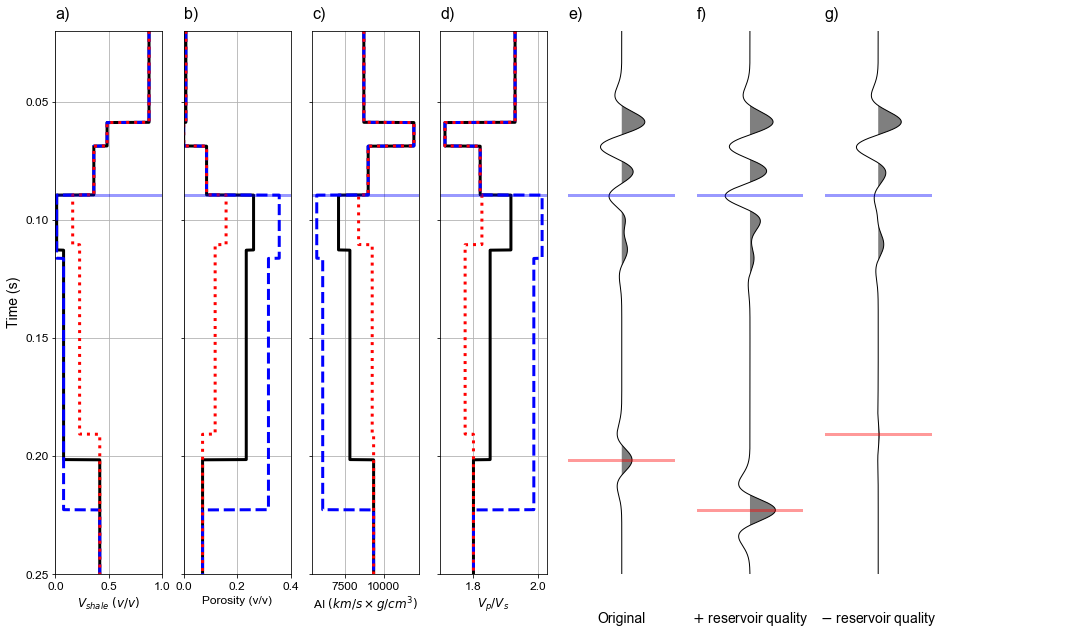

In [18]:
#############################################
#
#       PLOTTING HAPPENS BELOW HERE
#


#   Create the plot figure
fig, ax = plt.subplots(nrows=1,ncols=8,figsize=(18, 10))
fig.set_facecolor('white')

#   Plot log curves in two-way time
ax[0].plot(lit_digA, t, 'k', lw=3)
ax[0].plot(lit_digB, t, 'b--', lw=3)
ax[0].plot(lit_digC, t, 'r:', lw=3)
ax[0].set_ylim((min_plot_time,max_plot_time))
ax[0].set_xlim(0, 1.0)
ax[0].invert_yaxis()
ax[0].set_ylabel('Time (s)', fontsize = 14)
ax[0].set_xlabel(r'$V_{shale} \ (v/v)$', fontsize = 12)
ax[0].grid()

ax[1].plot(phi_digA, t, 'k', lw=3)
ax[1].plot(phi_digB, t, 'b--', lw=3)
ax[1].plot(phi_digC, t, 'r:', lw=3)
ax[1].set_ylim((min_plot_time,max_plot_time))
ax[1].set_xlim(0, 0.4)
ax[1].invert_yaxis()
ax[1].set_yticklabels('')
ax[1].set_xlabel('Porosity (v/v)', fontsize = 12)
ax[1].grid()


ax[2].plot(vp_digA * rho_digA, t, 'k', lw=3)
ax[2].plot(vp_digB * rho_digB, t, 'b--', lw=3)
ax[2].plot(vp_digC * rho_digC, t, 'r:', lw=3)
ax[2].set_ylim((min_plot_time,max_plot_time))
ax[2].invert_yaxis()
ax[2].set_yticklabels('')
ax[2].set_xlabel('AI ' + r'$(km/s \times g/cm^3)$', fontsize = 12)
ax[2].grid()

ax[3].plot(vp_digA / vs_digA, t, 'k', lw=3)
ax[3].plot(vp_digB / vs_digB, t, 'b--', lw=3)
ax[3].plot(vp_digC / vs_digC, t, 'r:', lw=3)
ax[3].set_ylim((min_plot_time,max_plot_time))
ax[3].invert_yaxis()
ax[3].set_yticklabels('')
ax[3].set_xlabel(r'$V_p/V_s$', fontsize = 12)
ax[3].grid()

# Plot post-stack trace
pst = syn_zoep_pp1.T.sum(axis=1) # Stacked trace
ax[4].plot(pst,t,'k',lw=1)
ax[4].fill_betweenx(t, pst, 0, pst>0, facecolor='k', linewidth=0,alpha=0.5)
ax[4].set_ylim((min_plot_time,max_plot_time))
ax[4].invert_yaxis()
ax[4].set_axis_off()
ax[4].set_title('Original', fontsize=14, y=-0.1)
ax[4].set_xlim(-15,15)
ax[4].axhline(lyr_timesA[0,4], color='red', lw=3, alpha=0.4)

pst = syn_zoep_pp2.T.sum(axis=1) # Stacked trace
ax[5].plot(pst,t,'k',lw=1)
ax[5].fill_betweenx(t, pst, 0, pst>0, facecolor='k', linewidth=0,alpha=0.5)
ax[5].set_ylim((min_plot_time,max_plot_time))
ax[5].invert_yaxis()
ax[5].set_axis_off()
ax[5].set_title(r'$+$' + ' reservoir quality', fontsize=14, y=-0.1)
ax[5].set_xlim(-15,15)
ax[5].axhline(lyr_timesB[0,4], color='red', lw=3, alpha=0.4)


pst = syn_zoep_pp3.T.sum(axis=1) # Stacked trace
ax[6].plot(pst,t,'k',lw=1)
ax[6].fill_betweenx(t, pst, 0, pst>0, facecolor='k', linewidth=0,alpha=0.5)
ax[6].set_ylim((min_plot_time,max_plot_time))
ax[6].invert_yaxis()
ax[6].set_axis_off()
ax[6].set_title(r'$-$' + ' reservoir quality', fontsize=14, y=-0.1)
ax[6].set_xlim(-15,15)
ax[6].axhline(lyr_timesC[0,4], color='red', lw=3, alpha=0.4)

ax[7].set_axis_off()

alphabet = []
for letter in range(97,123):
    alphabet.append(chr(letter))

for n in range(0,len(ax)-1):
    ax[n].text(ax[n].get_xlim()[0], 0.015, alphabet[n]+')',size=16, weight='normal')
    ax[n].axhline(lyr_timesA[0,2], color='blue', lw=3, alpha=0.4)
       
    
plt.savefig('Love1_AVO_pst.png',dpi = 400)

plt.show()


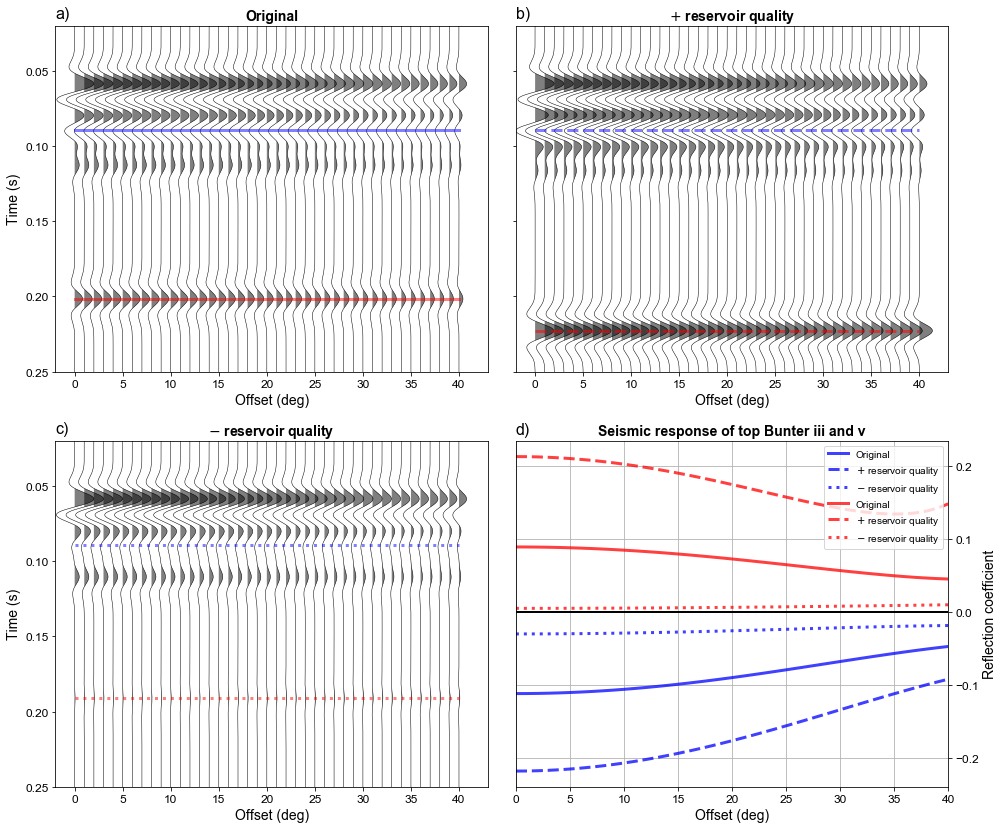

In [19]:

fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.065, hspace=0.2) # set the spacing between axes. 
fig.set_facecolor('white')

# Plot pre-stack traces
ax1 = fig.add_subplot(gs[0])
plot_vawig(ax1, syn_zoep_pp1, t, excursion)
ax1.set_ylim((min_plot_time,max_plot_time))
ax1.plot(lyr_timesA[:,2], color='blue', lw=3, alpha = 0.5)
ax1.plot(lyr_timesA[:,4], color='red', lw=3, alpha = 0.5)
ax1.invert_yaxis()
ax1.set_xlabel('Offset (deg)', fontsize = 14)
ax1.set_title('Original', fontsize = 14,weight = 'bold')
ax1.set_ylabel('Time (s)', fontsize = 14)
ax1.xaxis.tick_bottom()
ax1.xaxis.set_label_position('bottom')
ax1.text(ax1.get_xlim()[0], 0.015, 'a)',size=16, weight='normal')

ax2 = fig.add_subplot(gs[1])
plot_vawig(ax2, syn_zoep_pp2, t, excursion)
ax2.set_ylim((min_plot_time,max_plot_time))
ax2.plot(lyr_timesB[:,2], color='blue', lw=3, alpha = 0.5,linestyle = '--')
ax2.plot(lyr_timesB[:,4], color='red', lw=3, alpha = 0.5,linestyle = '--')
ax2.invert_yaxis()
ax2.set_xlabel('Offset (deg)', fontsize = 14)
ax2.set_title(r'$+$' + ' reservoir quality', fontsize=14,weight = 'bold')
ax2.set_yticklabels('')
ax2.xaxis.tick_bottom()
ax2.xaxis.set_label_position('bottom')
ax2.text(ax1.get_xlim()[0], 0.015, 'b)',size=16, weight='normal')

ax3 = fig.add_subplot(gs[2])
plot_vawig(ax3, syn_zoep_pp3, t, excursion)
ax3.set_ylim((min_plot_time,max_plot_time))
l_int3 = ax3.plot(lyr_timesC[:,2], color='blue', lw=3, alpha = 0.5,linestyle = ':')
l_int5 = ax3.plot(lyr_timesC[:,4], color='red', lw=3, alpha = 0.5,linestyle = ':')
ax3.invert_yaxis()
ax3.set_xlabel('Offset (deg)', fontsize = 14)
ax3.set_title(r'$-$' + ' reservoir quality', fontsize=14,weight = 'bold')
ax3.set_ylabel('Time (s)', fontsize = 14)
ax3.xaxis.tick_bottom()
ax3.xaxis.set_label_position('bottom')
ax3.text(ax1.get_xlim()[0], 0.015, 'c)',size=16, weight='normal')

ax4 = fig.add_subplot(gs[3])
l_syn1, = ax4.plot(line3A, color='blue', linewidth=3, linestyle = '-', alpha = 0.75)
l_syn2, = ax4.plot(line3B, color='blue', linewidth=3, linestyle = '--', alpha = 0.75)
l_syn3, = ax4.plot(line3C, color='blue', linewidth=3, linestyle = ':', alpha = 0.75)

l_syn4, = ax4.plot(line5A, color='red', linewidth=3, linestyle = '-', alpha = 0.75)
l_syn5, = ax4.plot(line5B, color='red', linewidth=3, linestyle = '--', alpha = 0.75)
l_syn6, = ax4.plot(line5C, color='red', linewidth=3, linestyle = ':', alpha = 0.75)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_ylabel('Reflection coefficient', fontsize = 14)
ax4.grid()
ax4.set_xlim(0,40)
ax4.set_xlabel('Offset (deg)', fontsize = 14)
ax4.text(ax4.get_xlim()[0], ax4.get_ylim()[1] + 0.01, 'd)',size=16, weight='normal')
ax4.set_title('Seismic response of top Bunter iii and v', fontsize = 14, weight = 'bold')
ax4.axhline(y = 0, color = 'black', lw = 2)
plt.legend([l_syn1, l_syn2, l_syn3, l_syn4, l_syn5, l_syn6], 
           ['Original', r'$+$' + ' reservoir quality',r'$-$' + ' reservoir quality',
           'Original', r'$+$' + ' reservoir quality',r'$-$' + ' reservoir quality'], loc=0)

#   Save the plot
plt.savefig('Love1_AVO_prest.png',dpi = 400)

#   Display the plot
plt.show()

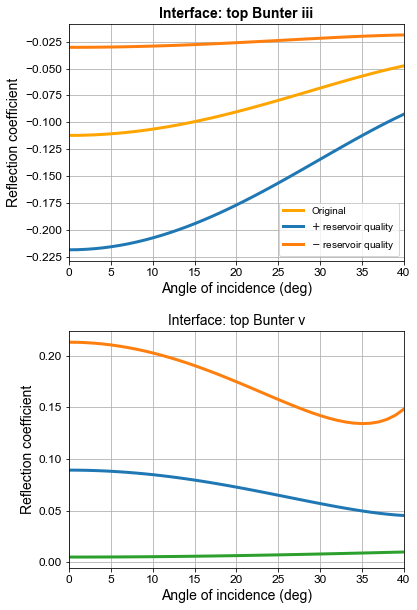

In [20]:
#   Plot Zoeppritz and convolved reflectivity curves    

#   Create the plot figure
fig = plt.figure(figsize=(6, 10))
gs = gridspec.GridSpec(2, 1)
gs.update(wspace=0.25, hspace=0.3) # set the spacing between axes. 
fig.set_facecolor('white')

ax1 = fig.add_subplot(gs[0])

l_syn1, = ax1.plot(line3A, color='orange', linewidth=3)
l_syn2, = ax1.plot(line3B, linewidth=3)
l_syn3, = ax1.plot(line3C, linewidth=3)
#l_rc1, = ax.plot( rc_zoep_pp1[:,2], '--', color='blue', lw=3)

ax1.set_xlim(0,40)
ax1.grid()
ax1.set_xlabel('Angle of incidence (deg)', fontsize = 14)
ax1.set_ylabel('Reflection coefficient', fontsize = 14)
ax1.set_title('Interface: top Bunter iii', fontsize = 14,weight = 'bold')
plt.legend([l_syn1, l_syn2, l_syn3], 
           ['Original', r'$+$' + ' reservoir quality',r'$-$' + ' reservoir quality'], loc=0)

ax2 = fig.add_subplot(gs[1])
l_syn2, = ax2.plot(line5A, linewidth=3)
l_syn2, = ax2.plot(line5B, linewidth=3)
l_syn3, = ax2.plot(line5C, linewidth=3)
#l_rc2, = ax4.plot( rc_zoep_pp[:,4], '--', color='red', lw=3)

ax2.set_xlim(0,40)
ax2.grid()
ax2.set_xlabel('Angle of incidence (deg)', fontsize = 14)
ax2.set_ylabel('Reflection coefficient', fontsize = 14)
ax2.set_title('Interface: top Bunter v', fontsize = 14)

plt.show()

Fig caption: AVO data analysis

The 2D pre-stack data studied at Give are old and have several issues in for the top Bunter iii and v surfaces, such as interfering remnant multiples, ringing on the near stack, residual moveout, amplitudes fading with offset, coherent noise on gathers and occasionally dead traces within a gather. The amplitude strength also varies significantly laterally, and several gathers close to the Løve-1 well position did not provide any good data conditions for any robust AVO analysis. Figure x shows a pre-stack seismic gather at CDP position xxx, located south of the Løve-1 well. By focusing on the top Bunter iii surface, we see that there are some small tendencys of decreasing amplitude with increasing offset, but the overall quality of the reflection events are poor and we were unable to improve the the gathers any further from previous reprocessings. Hence, we suspected that the datafoundation were inadequate for any robust quantitative interpretations. Still, the modeled AVO provides an interesting rock physics catalogue for different geological scenarios, and the post-stack traces seems to be more suitable for comparison with the seismic data, even though loosing offset data constrains our ability to investigate a higher number of reservoir parameters. 

The analysis in this study therefore focused more on the post-stack seismic data. A post-stack seismic inversion was therefore performed to achieve the acoustic impedance which is highly linked to the reservoir porosity. 

In [21]:
cmp = pd.read_csv('cmp.txt',header=None)
time = np.arange(0,2004,4)
traces = pd.read_csv('amp.txt',header=None,names=cmp.iloc[0])

In [22]:
import segyio
import numpy as np
from shutil import copyfile
from scipy.interpolate import spline

cmp_love1 = 319 # @ Løve-1 position
cmp_exp = 290 # Extrapolate away from well 

file = 'angle_gather.sgy'
with segyio.open(file, iline=21) as f:
    #print(f.offsets)
    #print(f.ilines)
    #print(f.trace[318])
    offsets = f.offsets
    gather_love = np.asarray([np.copy(x) for x in f.iline[cmp_love1,:]])
    gather_exp = np.asarray([np.copy(x) for x in f.iline[cmp_exp,:]])
    
time = np.linspace(1.1,1.7,gather_love.shape[-1])
time_sm = np.linspace(time.min(), time.max(), len(time)*10)

gather_sm_love = np.zeros([len(time_sm),gather_love.shape[0]])
gather_sm_exp = np.zeros([len(time_sm),gather_exp.shape[0]])

for i in range(0,gather_love.shape[0]):
    gather_sm_love[:,i] = spline(time,gather_love[i,0,:],time_sm)
    gather_sm_exp[:,i] = spline(time,gather_exp[i,0,:],time_sm)
  
# Surfaces @ Løve-1    
love_bunter3 = 1.332
love_bunter5 = 1.438

# Surfaces @ Løve-1    
exp_bunter3 = 1.368
exp_bunter5 = 1.473


C:\Users\kenb\.conda\envs\obspy\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning:

`spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.

C:\Users\kenb\.conda\envs\obspy\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning:

`spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.



In [23]:
# Use Hampson Russel to extract the A and B parameters in the 2-term Aki & Richards equation R = A+B*sin(theta)^2
theta = np.linspace(3,19,8) # First and last trace is at 3 and 19 degrees, and we have 8 "live" traces in our data
R_love_bunter3 = (2385.28/-1e3) + (-20348.45/-1e3)*(np.sin(np.deg2rad(theta)))**2
R_love_bunter5 = (-606.25/-1e3) + (3693/-1e3)*(np.sin(np.deg2rad(theta)))**2

R_exp_bunter3 = (5108.64/-1e3) + (-32694.57/-1e3)*(np.sin(np.deg2rad(theta)))**2
R_exp_bunter5 = (-2997.37/-1e3) + (24151.87/-1e3)*(np.sin(np.deg2rad(theta)))**2

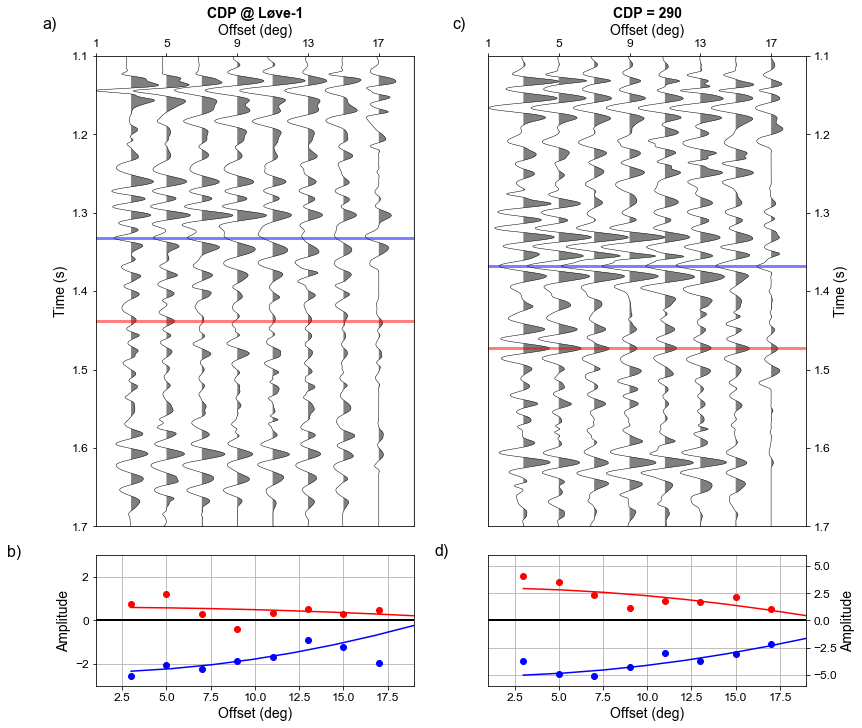

In [24]:
fig = plt.figure(constrained_layout=True,figsize=(12,10))
gs = fig.add_gridspec(3,2, hspace=0.5,wspace=1.5)
fig.set_facecolor('white')

ax1 = fig.add_subplot(gs[:-1,0])
plot_vawig(ax1, gather_sm_love.T/-1e3 , time_sm, 1)
ax1.set_ylim(time_sm.min(),time_sm.max())
ax1.axhline(y = love_bunter3, color='blue', lw=3, alpha = 0.5)
ax1.axhline(y = love_bunter5, color='red', lw=3, alpha = 0.5)
#ax1.plot(lyr_timesA[:,4], color='red', lw=3, alpha = 0.5)
ax1.invert_yaxis()
ax1.set_xlabel('Offset (deg)', fontsize = 14)
ax1.set_title('CDP @ Løve-1', fontsize = 14,weight = 'bold')
ax1.set_ylabel('Time (s)', fontsize = 14)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.text(x = ax1.get_xlim()[0]-0.5, y = ax1.get_ylim()[1]-0.035, s = 'a)',size=16, weight='normal')
ax1.set_xlim(0,9)
ax1.set_xticklabels(['1','5','9','13','17'])

offset_range = range(1,9)

ax2 = fig.add_subplot(gs[-1,0])
ax2.plot(offsets[offset_range],-0.001*gather_sm_love[(np.argmin(np.abs(time_sm - love_bunter3))),offset_range],'b.',ms=12)
ax2.plot(offsets[offset_range],-0.001*gather_sm_love[(np.argmin(np.abs(time_sm - love_bunter5))),offset_range],'r.',ms=12)
ax2.plot(theta,R_love_bunter3,'b-')
ax2.plot(theta,R_love_bunter5,'r-')
ax2.set_xlim(1,19)
ax2.set_xlabel('Offset (deg)', fontsize = 14)
ax2.set_ylabel('Amplitude', fontsize = 14)
ax2.axhline(y = 0, color='black', lw=2)
ax2.text(x = ax2.get_xlim()[0]-5, y = ax2.get_ylim()[1]+1.5, s = 'b)',size=16, weight='normal')
ax2.set_ylim(-3,3)
ax2.grid()

ax3 = fig.add_subplot(gs[:-1,1])
plot_vawig(ax3, gather_sm_exp.T/-1e3 , time_sm, 1)
ax3.set_ylim(time_sm.min(),time_sm.max())
ax3.axhline(y = exp_bunter3, color='blue', lw=3, alpha = 0.5)
ax3.axhline(y = exp_bunter5, color='red', lw=3, alpha = 0.5)
#ax3.plot(lyr_timesA[:,4], color='red', lw=3, alpha = 0.5)
ax3.invert_yaxis()
ax3.set_xlabel('Offset (deg)', fontsize = 14)
ax3.set_title('CDP = {}'.format(cmp_exp), fontsize = 14,weight = 'bold')
ax3.xaxis.tick_top()
ax3.xaxis.set_label_position('top')
ax3.text(x = ax3.get_xlim()[0], y = ax3.get_ylim()[1]-0.035, s = 'c)',size=16, weight='normal')
ax3.set_xlim(0,9)
ax3.set_xticklabels(['1','5','9','13','17'])
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Time (s)', fontsize=14)

ax4 = fig.add_subplot(gs[-1,-1])
ax4.plot(offsets[offset_range],-0.001*gather_sm_exp[(np.argmin(np.abs(time_sm - exp_bunter3))),offset_range],'b.',ms=12)
ax4.plot(offsets[offset_range],-0.001*gather_sm_exp[(np.argmin(np.abs(time_sm - exp_bunter5))),offset_range],'r.',ms=12)
ax4.plot(theta,R_exp_bunter3,'b-')
ax4.plot(theta,R_exp_bunter5,'r-')
ax4.set_xlim(1,19)
ax4.set_xlabel('Offset (deg)', fontsize = 14)
ax4.set_ylabel('Amplitude', fontsize = 14)
ax4.axhline(y = 0, color='black', lw=2)
ax4.text(x = ax4.get_xlim()[0]-3, y = ax4.get_ylim()[1]+1.5, s = 'd)',size=16, weight='normal')
ax4.set_ylim(-6,6)
ax4.grid()
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

#plt.savefig('Love1_AVO_analysis.png',dpi = 400)

plt.show()

The seismic data has been reprocessed to be suitable for AVO analysis (extract text from report). We have also applied processes steps in order to fix migration move-out problems (trim statics) and radon multiple corrections. The offfset-to-angle transformation is based on velocity logs from the Løve-1 well. 

Figure Xa shows the seismic gather at the position of the Løve-1 well with Top Bunter iii (blue) and top Bunter v (red) interpreted interfaces projected on top. Figure Xb shows the corresponding Amplitude vs. Offset (AVO) cross-plot for the two interfaces. Because the AVO modeling indicates that there might be some intereference issues, and, the seismic amplitude in this area seems to be weaker than what can be observed when moving laterally, we also considered a seismic gather further south in Figure X(c-d) where the seismic events are more apparent. However, the AVO signatures are similar and consistent in both positions.

Generally, the low data quality of the seismic gathers sets some constraints for doing any rigorous quantitative seismic interpretation with high accuracy. However, the seismic events are still consistent with the trends in from the AVO modeling; the top Bunter iii exhibit a negative intercept with a positive gradient, and Bunter v exhibits a positive intercept with a negative gradient. This is of course a positive result, but we believe that the data quality makes it more difficult to distingusih varying reservoir quality and the inherent non-uniquess of rock physics. The methodology has certainly a strong potential and value in quantitatve interpretation in a exploration phase, particularly if there are any closeby wells that can be used for the AVO modeling. ALternatively, if well log data was available, rock physics depth trends could be applied to outline the AVO signature for different reservoir scenarios. 

